# DOPP Project - Terrorism and Wealth


#### Hypotheses
* Does unemployment correlate with the terrorism within a country?
* Does GDP per capita correlate with terrorism within a country?
* Which economical and social factors influence terrorism?
* What data is necessary to predict terrorism in the next year?

#### Economical and Social Influences
* Unemployment
* GDP
* GDP per capita
* GDP per capita change%
* Life Expectancy

#### Definition of Terrorism
We define terrorism as the number of casualities by terrorist attacks in a country within a year.

#### Definition of Correlation
* A correlation is too weak or non existent if the correlation value is lower than absolute 0.3
* A correlation is weak if the correlation value is between absolute 0.3 and 0.7
* A correlation is high if the correlation value is higher than absolute 0.7


#### Datasets
* Terrorism dataset from https://www.kaggle.com/START-UMD/gtd
* GDP dataset from https://data.worldbank.org/indicator/NY.GDP.MKTP.CD
* GDP per capita from https://data.worldbank.org/indicator/NY.GDP.PCAP.CD
* GDP per capita growth % https://data.worldbank.org/indicator/NY.GDP.PCAP.KD.ZG
* Unemployment total % https://data.worldbank.org/indicator/SL.UEM.TOTL.ZS
* Life Expectancy at birth in Years https://data.worldbank.org/indicator/SP.DYN.LE00.IN


Please note, that the names of the datasets may have been changed before reading in. Terrorism dataset is of format .csv while worldbank data is excel .xls. This is due to easier reading in. For the excel file the first 3 columns have to be deleted manually in MS Excel. The excel files that were used for the project are provided on https://github.com/msieder/terror aswell.

# Packages

In [1]:
import pandas as pd
import numpy as np
#pip install pycountry
#import pycountry
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import math
#pip install plotly
import plotly as py 
import plotly.graph_objs as go 
import plotly.express as px
# some more libraries to plot graph 
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot 
  


# Reading in Data
We are going to:
* Read in 6 different datasets
* Fix column names for terrorism dataset
* Select a subset of terrorism dataset
* Compute Casualities (Killed+Wounded)
* remove 2018 and 2019 data in world bank (many NAs and no corresponding terrorism data)
* Focus on data starting between 1992 and 2017
* Get general statistics about the datasets

# Understanding the data
In order to understand the data we should first understand the connecting terms to the specific field which the data is about. Hereby, we analyze the characteristics of the dataset (size, attribute types value ranges, sparsity, min/max values, outliers, missing values ans so on, to have a conmprehensive picture about the data we are working with.

In [2]:
# data file paths
glob_terr_data_path = "./Data/globalterrorismdb_0718dist.csv"
gdp_total_data_path = "./Data/gdp_total.xls"
gdp_capita_data_path = "./Data/gdp_capita.xls"
unemployment_data_path = "./Data/unemployment.xls"
life_data_path = "./Data/life.xls"
capita_growth_data_path = "./Data/capita_growth.xls"

### Dataset 1: Data from Global Terrorism DB
Terrorism dataset from https://www.kaggle.com/START-UMD/gtd

To have a better understanding let's describe the attributes:
* Year, Month and Day: date of incident
* Country, Region: name of geographical region and country
* Latitude, Longitude: exact location of incident
* AttackType: can be bombing, armed assault, assasination, etc.
* Killed: number of killed people
* Wounded: number of wounded people
* Target: exact object, person or group of people which was the aim of the attack
* Group: terrorist group which officially claimed to be the operator behind the action
* Target_type: target which can be infrastructural entity, utilities, transportation, citizens, officials or other people
* Weapon_type: type of equipment which was used to commit the attacks, such as firearms or explosives
* Motive: motivation behinf the attack

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.



Head of terror data: 
        Year  Month  Day      Country                       Region  \
41338  1991      1   30       Jordan   Middle East & North Africa   
44962  1991      1    0  Philippines               Southeast Asia   
44963  1991      1    0    Guatemala  Central America & Caribbean   
44964  1991      1    0  Philippines               Southeast Asia   
44965  1991      1    1     Colombia                South America   

                        City   Latitude   Longitude  \
41338                  Amman  31.950001   35.933331   
44962                  Lopez        NaN         NaN   
44963               El Subin  16.633333  -90.183333   
44964                 Conner  17.795745  121.322798   
44965  Buenaventura district   3.881820  -77.070420   

                           AttackType  Killed  Wounded  \
41338  Facility/Infrastructure Attack     0.0      0.0   
44962               Bombing/Explosion     NaN      NaN   
44963                   Assassination     0.0      0.0   

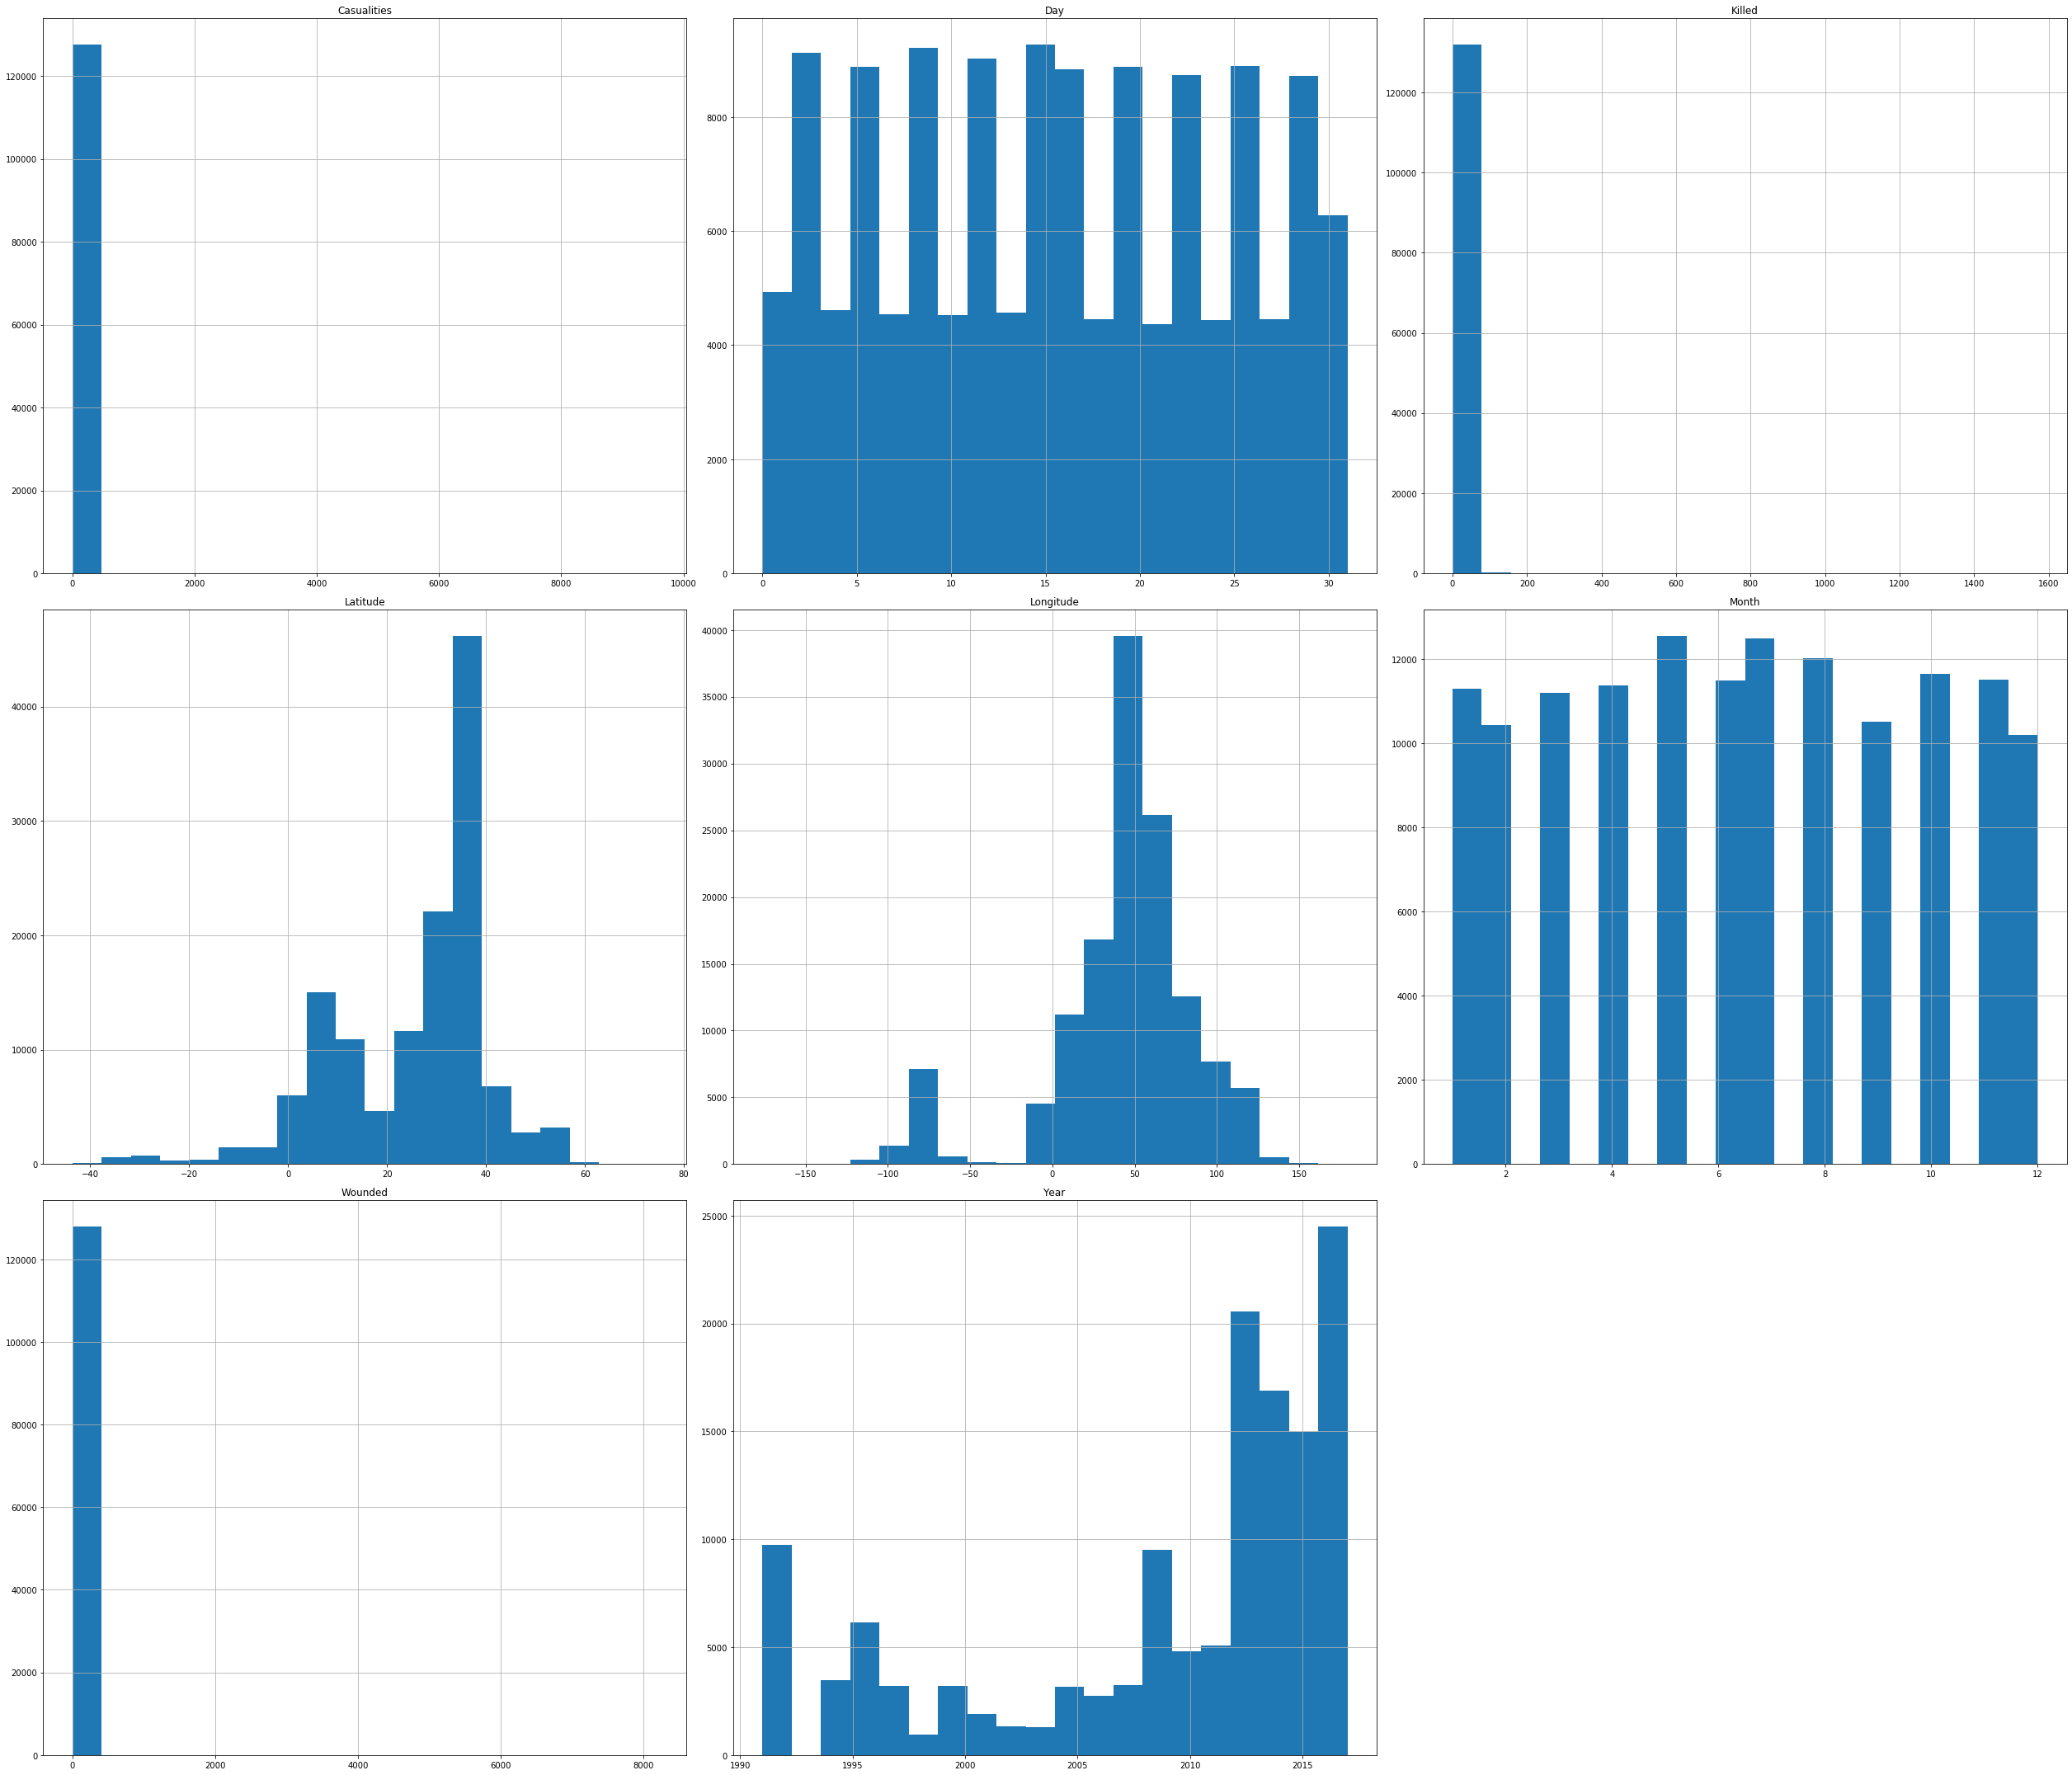

Categorical attributes 
 ['Target_type', 'Summary', 'Region', 'Weapon_type', 'Country', 'Target', 'Group', 'AttackType', 'City', 'Motive']

Middle East & North Africa     46007
South Asia                     41451
Sub-Saharan Africa             15282
Southeast Asia                 10857
South America                   7195
Western Europe                  6788
Eastern Europe                  5017
Central America & Caribbean     1620
North America                   1265
Central Asia                     563
East Asia                        515
Australasia & Oceania            170
Name: Region, dtype: int64

Iraq                   24600
Pakistan               14068
Afghanistan            12703
India                  10359
Philippines             5546
                       ...  
Antigua and Barbuda        1
Wallis and Futuna          1
International              1
North Korea                1
Guadeloupe                 1
Name: Country, Length: 191, dtype: int64

Unknown                    

In [3]:
terror = pd.read_csv(glob_terr_data_path,encoding="ISO-8859-1")
terror.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','country_txt':'Country',
                       'region_txt':'Region','city':'City','latitude':'Latitude',
                       'longitude':'Longitude','attacktype1_txt':'AttackType',
                       'target1':'Target','nkill':'Killed','nwound':'Wounded',
                       'summary':'Summary','gname':'Group','targtype1_txt':'Target_type',
                       'weaptype1_txt':'Weapon_type','motive':'Motive'},
              inplace=True)
terror=terror[['Year','Month','Day','Country','Region','City','Latitude','Longitude','AttackType',
               'Killed','Wounded','Target','Summary','Group','Target_type','Weapon_type','Motive']]
terror['Casualities']=terror['Killed']+terror['Wounded']
terror = terror[terror.Year>=1991]

terror_head  = terror.head(5)
terror_stats = terror.loc[:,['Year',
                'Latitude',
                'Longitude',
                'Killed',
                'Wounded',
                'Casualities']]

print("Head of terror data: \n",terror_head)
print("Basic statistics about terror data: \n", terror_stats.describe())
print("Number of Null values by column \n", terror.isnull().sum(axis=0))


terror_dropped = terror.dropna(how='all')
terror_dropped.hist(figsize=(35,30),
                  bins=20)
plt.tight_layout()
plt.show()

terror_cols = terror.columns
num_terror_cols = terror._get_numeric_data().columns
non_num_terror_cols = list(set(terror_cols) - set(num_terror_cols))
print("Categorical attributes \n",non_num_terror_cols)
print()
for col in ['Region', 'Country', 'Group', 'City', 'Target_type', 'Weapon_type', 'AttackType']:
    print(terror[col].value_counts())
    print()
    


terror data insights


### Dataset 2: GDP
GDP dataset from https://data.worldbank.org/indicator/NY.GDP.MKTP.CD

To have a better understanding let's describe the attributes:
* Country: Name of country
* CountryCode: 3 letter code of country
* 1990 - 2019: yearly GDP of given country


In [4]:
gdp = pd.read_excel(gdp_total_data_path)
gdp.rename(columns={"Country Name":"CountryName","Country Code":"CountryCode"},inplace=True)
gdp.drop(gdp.columns[[range(2,34)]], axis=1,inplace=True)
gdp.drop("2018", axis=1, inplace=True)
gdp.drop("2019", axis=1, inplace=True)
gdp.head(5)

gdp_head  = gdp.head(5)
gdp_stats = gdp.loc[:,[str(e) for e in list(range(1990,2018))]]

print("Head of GDP data: \n",gdp_head)
print("Basic statistics about GDP data: \n", gdp_stats.describe())
print("Number of Null values by column \n", gdp.isnull().sum(axis=0))

gdp_dropped = gdp.dropna(how='all')
gdp_dropped['avg'] = gdp_dropped.mean(axis=1)
print(gdp_dropped.loc[:,['CountryName','avg']].nlargest(10,'avg'))

Head of GDP data: 
    CountryName CountryCode          1990          1991          1992  \
0        Aruba         ABW  7.648871e+08  8.721387e+08  9.584632e+08   
1  Afghanistan         AFG           NaN           NaN           NaN   
2       Angola         AGO  1.122876e+10  1.060378e+10  8.307811e+09   
3      Albania         ALB  2.028554e+09  1.099559e+09  6.521750e+08   
4      Andorra         AND  1.029048e+09  1.106929e+09  1.210014e+09   

           1993          1994          1995          1996          1997  ...  \
0  1.082980e+09  1.245688e+09  1.320475e+09  1.379961e+09  1.531944e+09  ...   
1           NaN           NaN           NaN           NaN           NaN  ...   
2  5.768720e+09  4.438321e+09  5.538749e+09  7.526447e+09  7.648377e+09  ...   
3  1.185315e+09  1.880952e+09  2.392765e+09  3.199643e+09  2.258516e+09  ...   
4  1.007026e+09  1.017549e+09  1.178739e+09  1.223945e+09  1.180597e+09  ...   

           2008          2009          2010          2011         

/opt/conda/lib/python3.7/site-packages/pandas/core/indexes/base.py:4291: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



gdp results

### Dataset 3: GDP per Capita
GDP per capita from https://data.worldbank.org/indicator/NY.GDP.PCAP.CD

The same rules apply and the same terms are used here as at the GDP dataset, only difference is that now we have values per Capita per Country.


Head of GDP/capita data: 
    CountryName CountryCode          1990          1991          1992  \
0        Aruba         ABW  12307.311738  13496.003385  14046.503997   
1  Afghanistan         AFG           NaN           NaN           NaN   
2       Angola         AGO    947.704182    865.692730    656.361756   
3      Albania         ALB    617.230436    336.586995    200.852220   
4      Andorra         AND  18878.505969  19532.540150  20547.711790   

           1993          1994          1995          1996          1997  ...  \
0  14936.827039  16241.046325  16439.356361  16586.068436  17927.749635  ...   
1           NaN           NaN           NaN           NaN           NaN  ...   
2    441.200673    328.673295    397.179451    522.643807    514.295223  ...   
3    367.279225    586.416340    750.604449   1009.977668    717.380567  ...   
4  16516.471027  16234.809010  18461.064858  19017.174590  18353.059722  ...   

           2008          2009          2010          2011  

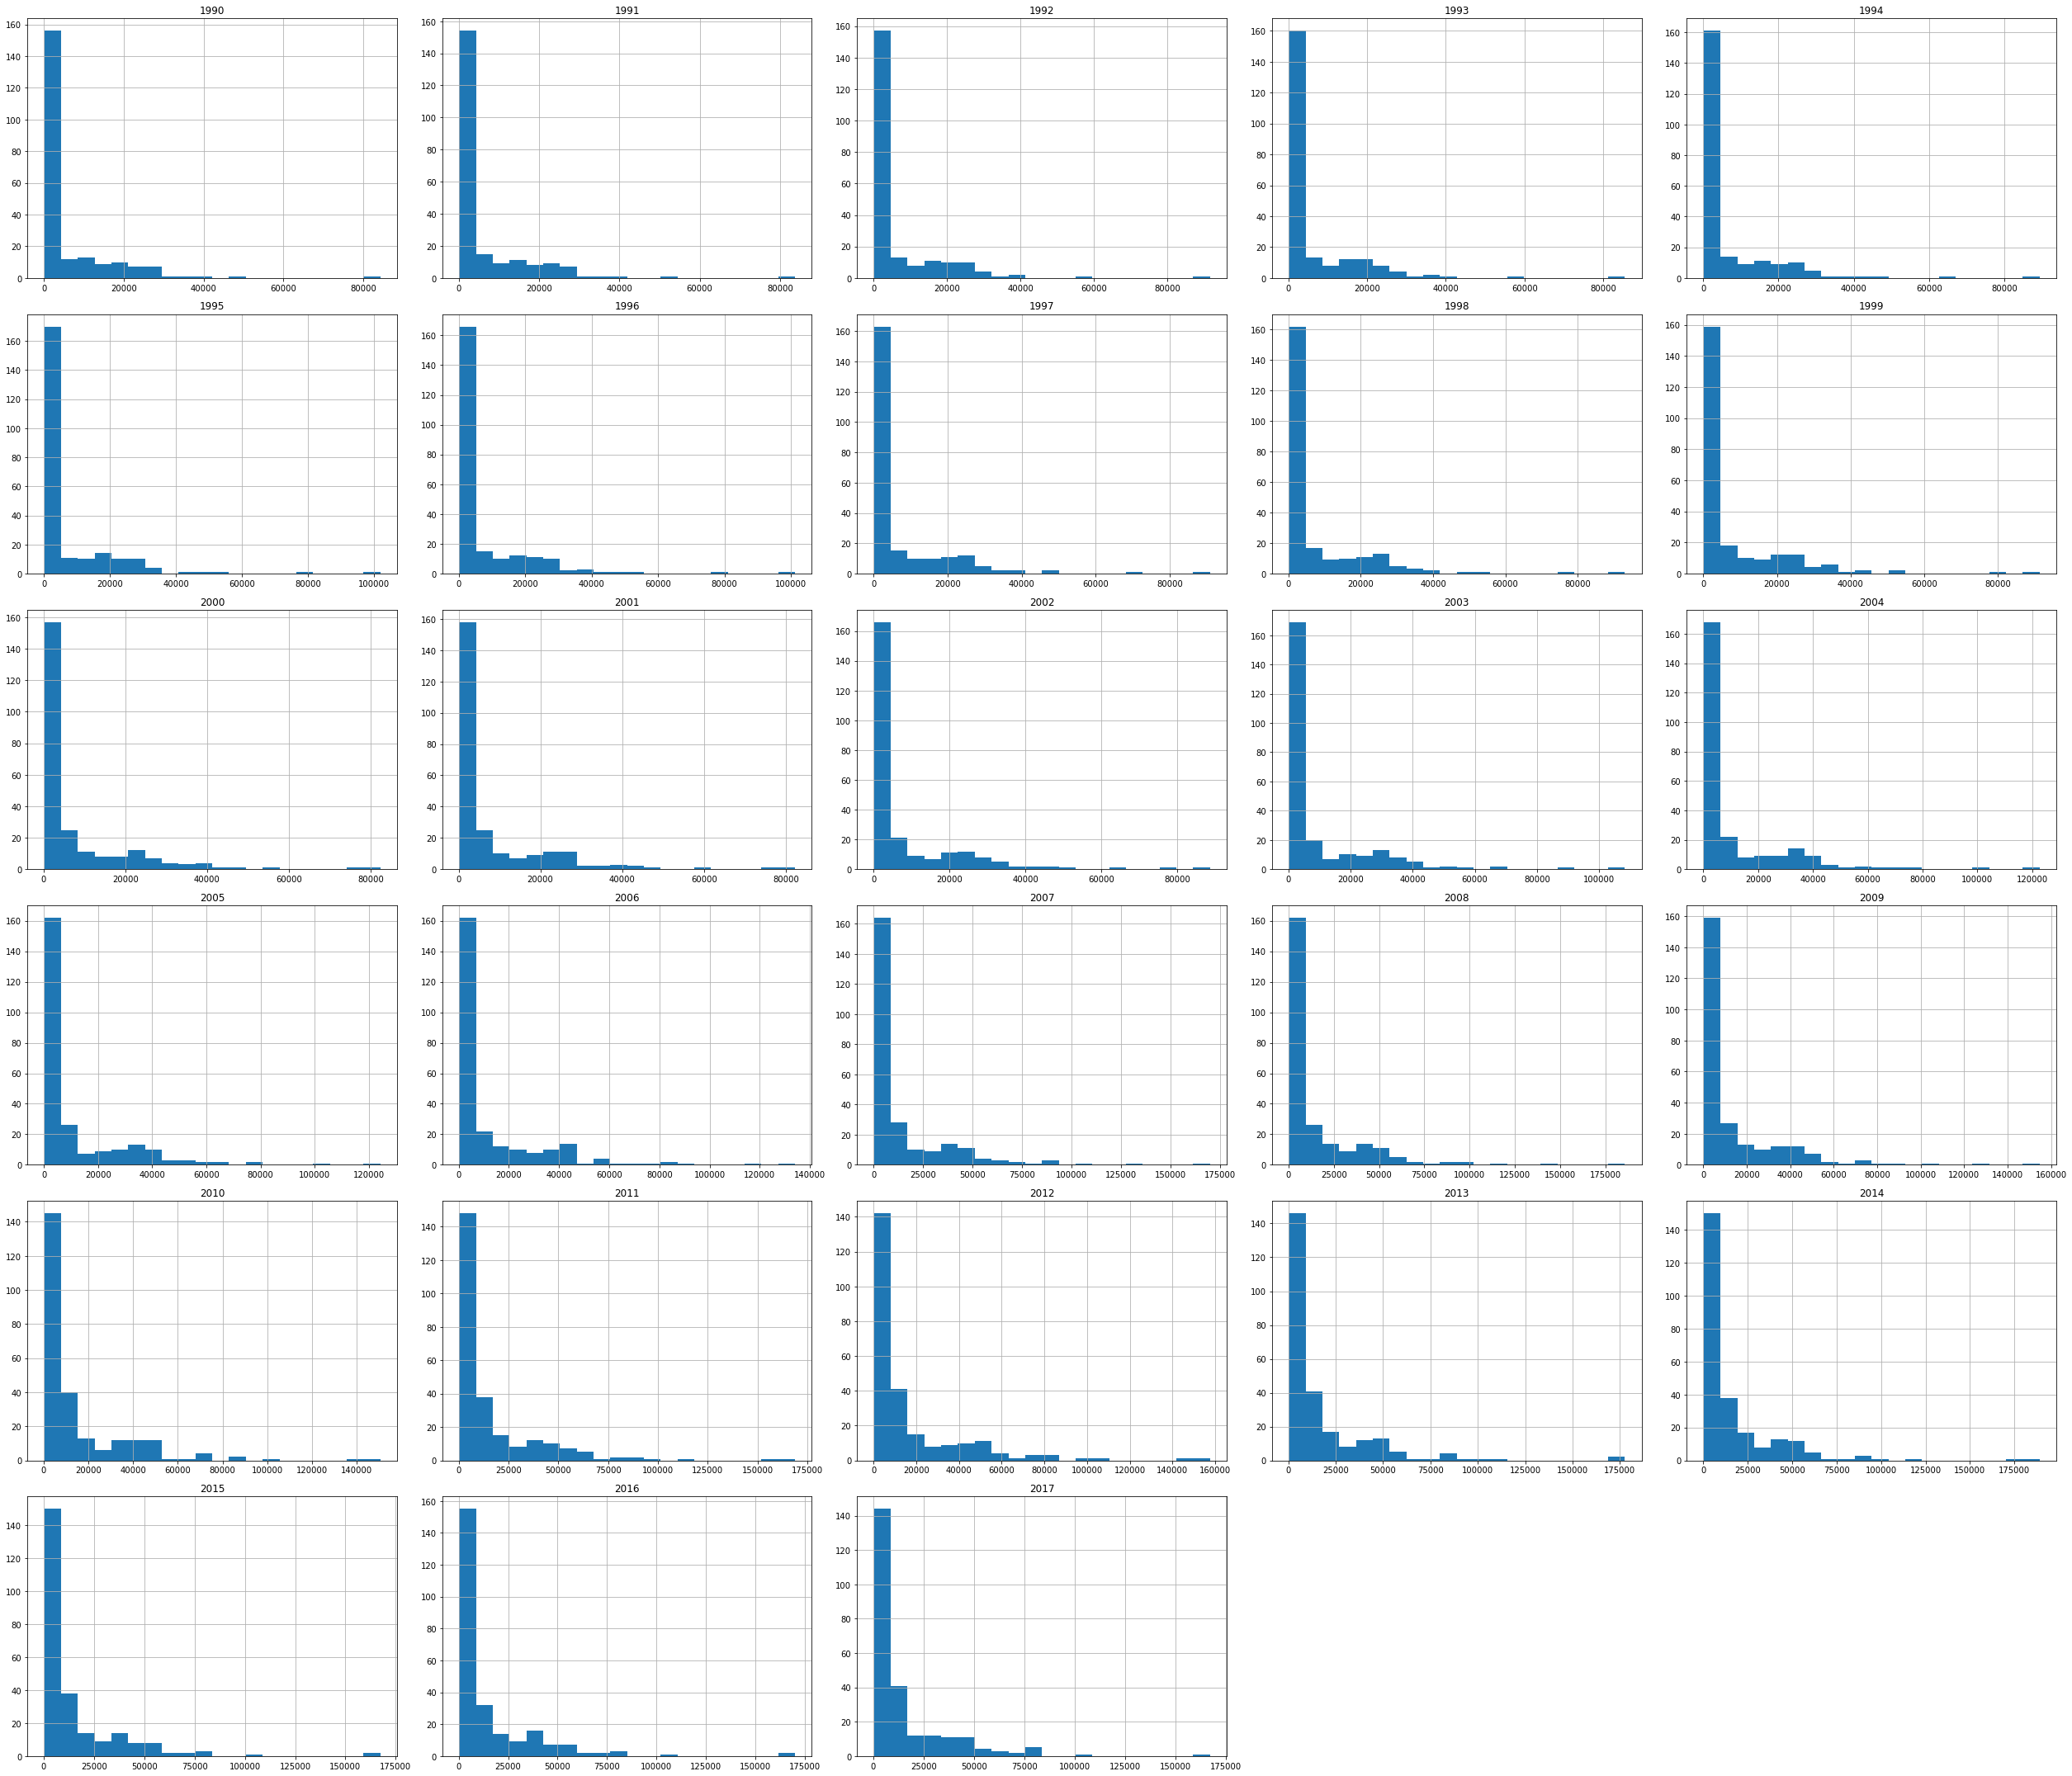

         CountryName            avg
147           Monaco  125432.680483
135    Liechtenstein  105002.775493
50    Cayman Islands   75463.629022
142       Luxembourg   75312.614917
25           Bermuda   61284.313495
175           Norway   59471.834794
210       San Marino   59009.555365
35       Switzerland   57601.354937
36   Channel Islands   51427.189627
106      Isle of Man   48600.155219


In [5]:
capita = pd.read_excel("./Data/gdp_capita.xls")
capita.rename(columns={"Country Name":"CountryName","Country Code":"CountryCode"},inplace=True)
capita.drop(capita.columns[[range(2,34)]], axis=1,inplace=True)
capita.drop("2018", axis=1, inplace=True)
capita.drop("2019", axis=1, inplace=True)

capita_head  = capita.head(5)
capita_stats = capita.loc[:,[str(e) for e in list(range(1990,2018))]]

print("Head of GDP/capita data: \n",capita_head)
print("Basic statistics about GDP/capita data: \n", capita_stats.describe())
print("Number of Null values by column \n", capita.isnull().sum(axis=0))

capita_dropped = capita.dropna(how='all')
capita_dropped.hist(figsize=(35,30),
                  bins=20)
plt.tight_layout()
plt.show()

capita_dropped['avg'] = capita_dropped.mean(axis=1)
print(capita_dropped.loc[:,['CountryName','avg']].nlargest(10,'avg'))

### Dataset 4: Unemployment data
Unemployment total % https://data.worldbank.org/indicator/SL.UEM.TOTL.ZS

To have a better understanding let's describe the attributes:
* Country: Name of country
* CountryCode: 3 letter code of country
* 1990 - 2019: percentage of unemployment in given country in given year

Head of Unemployment data: 
    CountryName CountryCode  1990       1991       1992    1993    1994  \
0        Aruba         ABW   NaN        NaN        NaN     NaN     NaN   
1  Afghanistan         AFG   NaN   2.976000   3.173000   3.463   3.612   
2       Angola         AGO   NaN  22.601999  20.924999  21.250  21.159   
3      Albania         ALB   NaN  16.781000  17.653000  17.681  17.527   
4      Andorra         AND   NaN        NaN        NaN     NaN     NaN   

        1995    1996       1997  ...    2008    2009    2010    2011    2012  \
0        NaN     NaN        NaN  ...     NaN     NaN     NaN     NaN     NaN   
1   3.653000   3.621   3.603000  ...   2.494   2.470   2.275   1.984   1.692   
2  21.148001  20.066  21.465000  ...  12.044  10.609   9.089   7.362   7.359   
3  17.607000  18.358  18.311001  ...  13.060  13.674  14.086  13.481  13.376   
4        NaN     NaN        NaN  ...     NaN     NaN     NaN     NaN     NaN   

     2013    2014    2015    2016    2017  
0

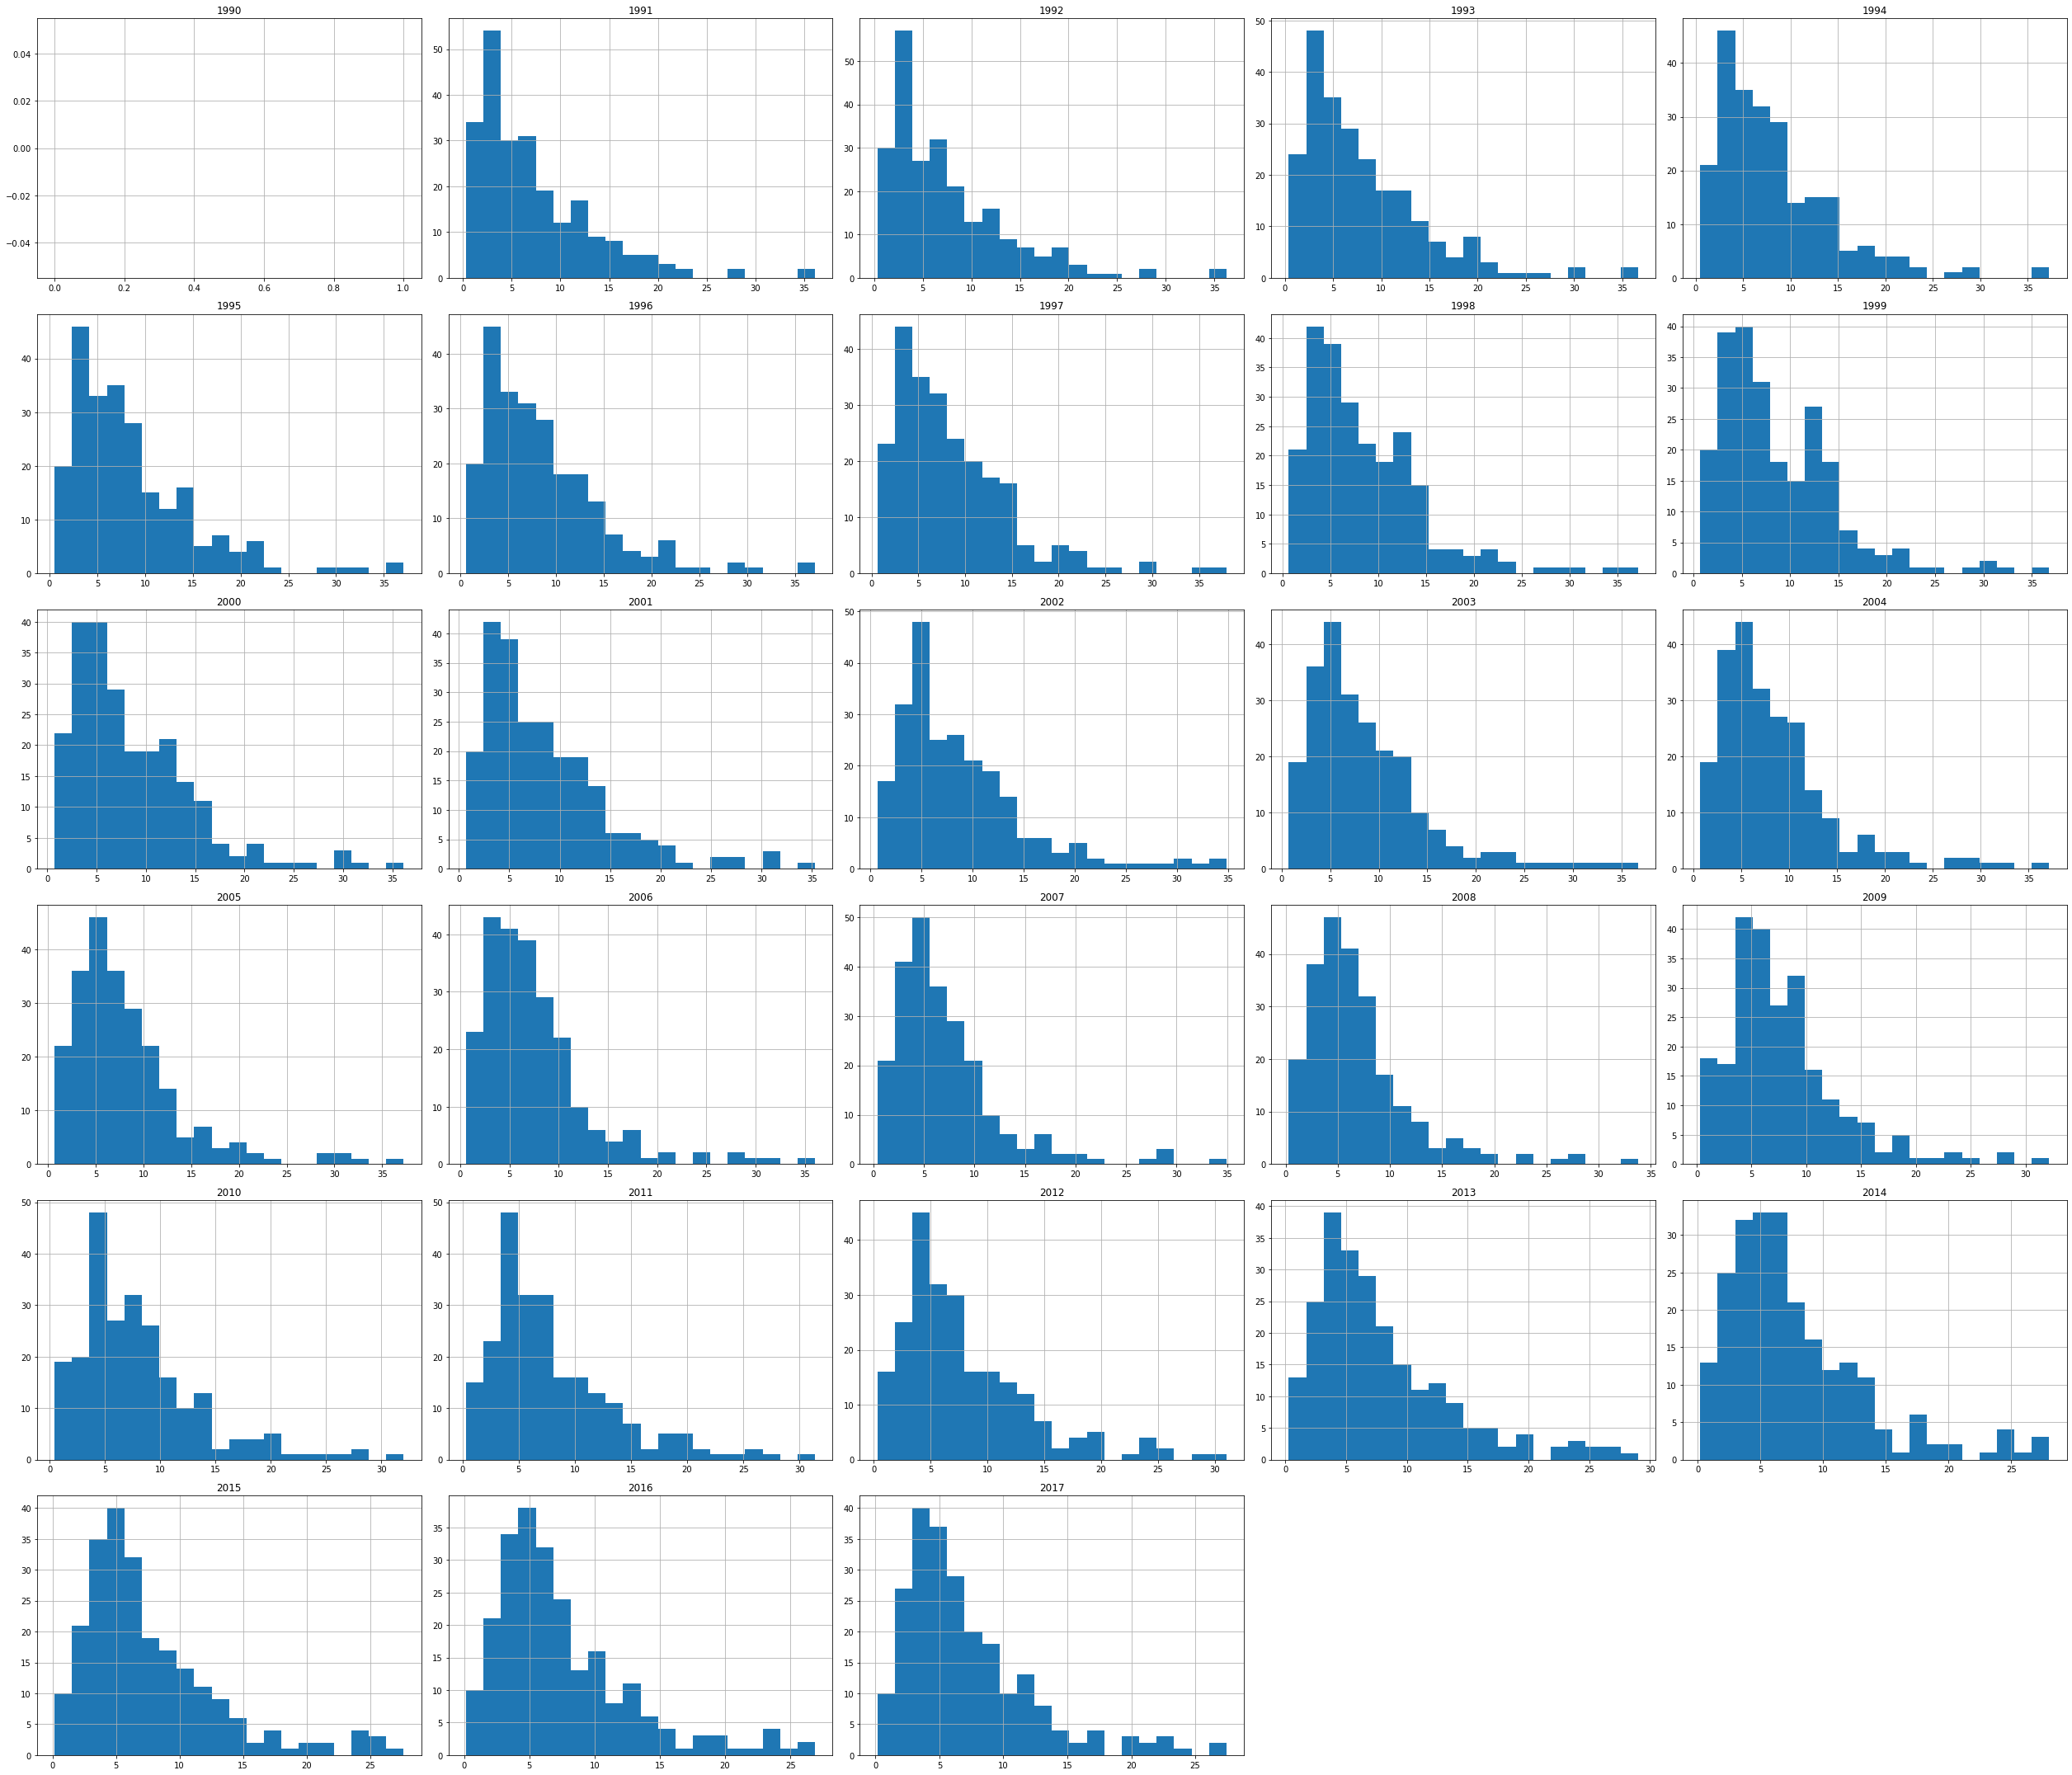

                        CountryName        avg
155                 North Macedonia  32.676260
139                         Lesotho  31.541444
261                    South Africa  27.949074
22           Bosnia and Herzegovina  25.213963
160                      Montenegro  25.151741
222                        Eswatini  24.670185
194              West Bank and Gaza  21.011111
169                         Namibia  20.871296
251  St. Vincent and the Grenadines  20.133593
58                          Algeria  18.951333


In [6]:
unemp = pd.read_excel("./Data/unemployment.xls")
unemp.rename(columns={"Country Name":"CountryName","Country Code":"CountryCode"},inplace=True)
unemp.drop(unemp.columns[[range(2,34)]], axis=1,inplace=True)
unemp.drop("2018", axis=1, inplace=True)
unemp.drop("2019", axis=1, inplace=True)

unemp_head  = unemp.head(5)
unemp_stats = unemp.loc[:,[str(e) for e in list(range(1990,2018))]]

print("Head of Unemployment data: \n",unemp_head)
print("Basic statistics about Unemployment data: \n", unemp_stats.describe())
print("Number of Null values by column \n", unemp.isnull().sum(axis=0))

unemp_dropped = unemp.dropna(how='all')
unemp_dropped.hist(figsize=(35,30),
                  bins=20)
plt.tight_layout()
plt.show()

unemp_dropped['avg'] = unemp_dropped.mean(axis=1)
print(unemp_dropped.loc[:,['CountryName','avg']].nlargest(10,'avg'))

### Dataset 5: Life Expectancy data
Life Expectancy at birth in Years https://data.worldbank.org/indicator/SP.DYN.LE00.IN

To have a better understanding let's describe the attributes:
* Country: Name of country
* CountryCode: 3 letter code of country
* 1990 - 2019: life expectancy at birth in years

Head of Life data: 
    CountryName CountryCode    1990    1991    1992    1993    1994    1995  \
0        Aruba         ABW  73.468  73.509  73.544  73.573  73.598  73.622   
1  Afghanistan         AFG  50.331  50.999  51.641  52.256  52.842  53.398   
2       Angola         AGO  45.306  45.271  45.230  45.201  45.201  45.246   
3      Albania         ALB  71.836  71.803  71.802  71.860  71.992  72.205   
4      Andorra         AND     NaN     NaN     NaN     NaN     NaN     NaN   

     1996    1997  ...    2008    2009    2010    2011    2012    2013  \
0  73.646  73.671  ...  74.725  74.872  75.017  75.158  75.299  75.441   
1  53.924  54.424  ...  59.930  60.484  61.028  61.553  62.054  62.525   
2  45.350  45.519  ...  53.243  54.311  55.350  56.330  57.236  58.054   
3  72.495  72.838  ...  75.912  76.221  76.562  76.914  77.252  77.554   
4     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   

     2014    2015    2016    2017  
0  75.583  75.725  75.868  76

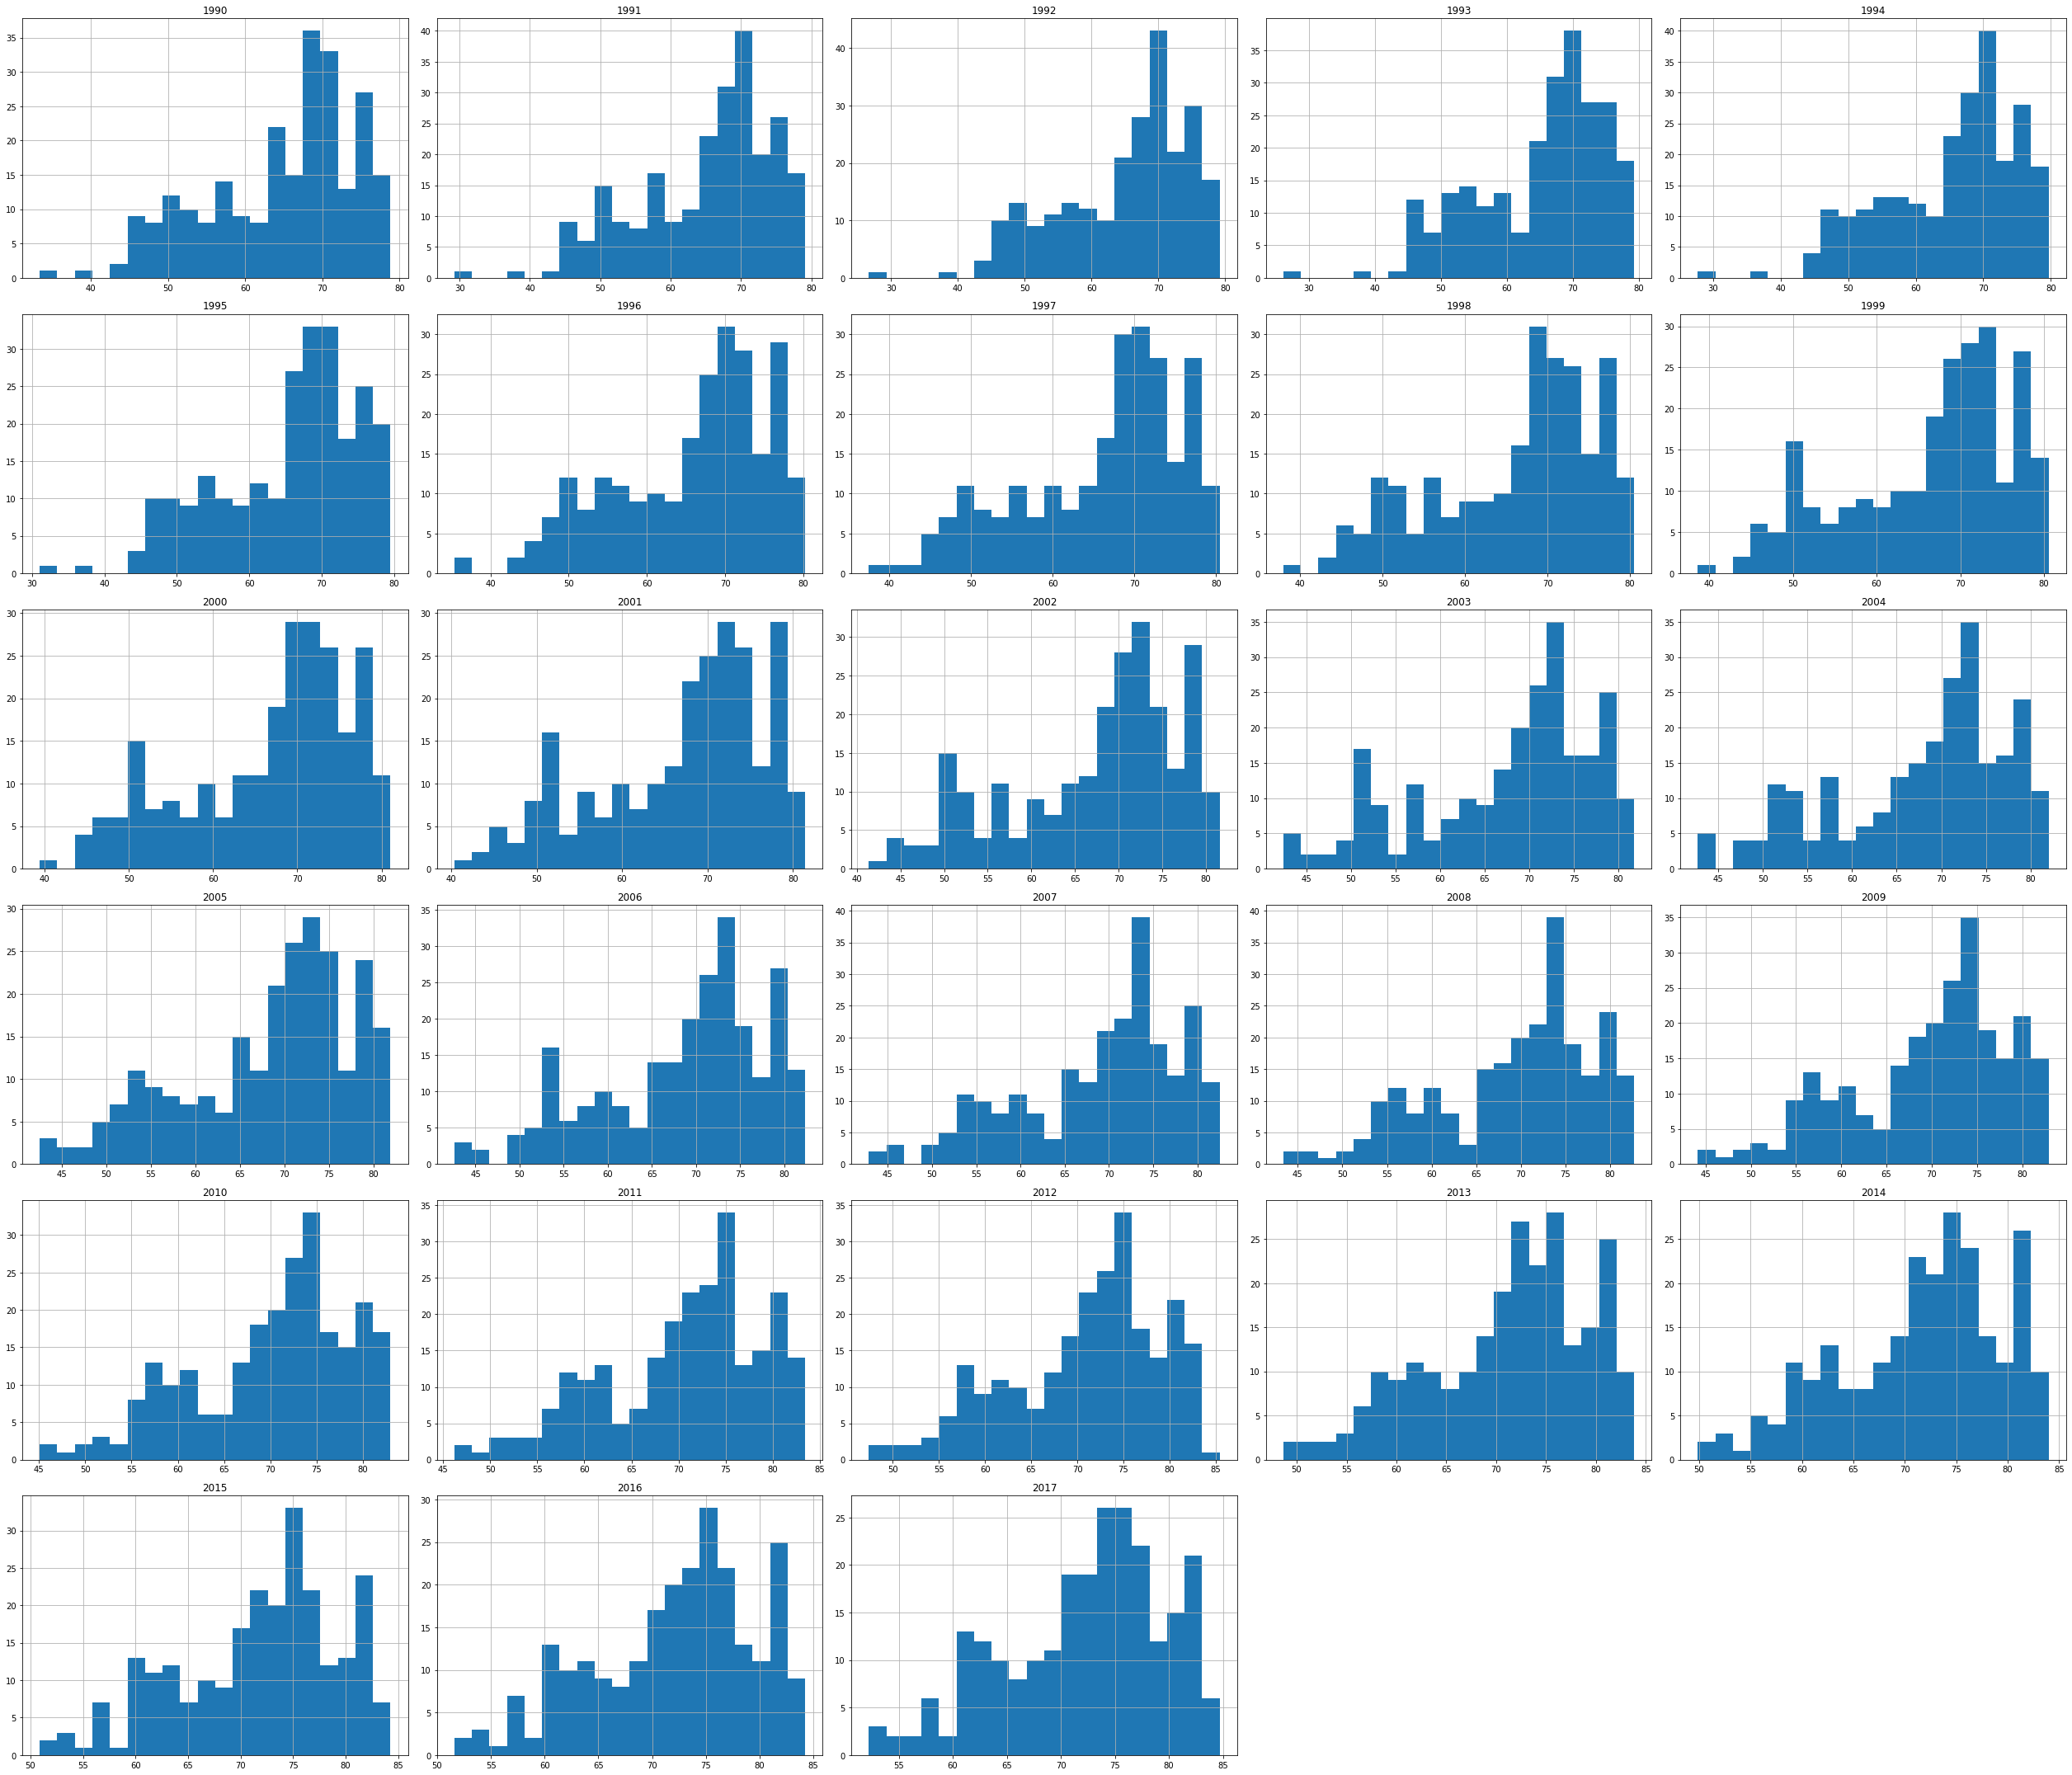

              CountryName        avg
210            San Marino  85.417073
50         Cayman Islands  82.190244
117                 Japan  81.598336
94   Hong Kong SAR, China  81.348258
144      Macao SAR, China  81.033893
35            Switzerland  80.657439
112               Iceland  80.600984
114                 Italy  80.348780
135         Liechtenstein  80.318394
221                Sweden  80.217962


In [7]:
life = pd.read_excel("./Data/life.xls")
life.rename(columns={"Country Name":"CountryName","Country Code":"CountryCode"},inplace=True)
life.drop(life.columns[[range(2,34)]], axis=1,inplace=True)
life.drop("2018", axis=1, inplace=True)
life.drop("2019", axis=1, inplace=True)

life_head  = life.head(5)
life_stats = life.loc[:,[str(e) for e in list(range(1990,2018))]]

print("Head of Life data: \n",life_head)
print("Basic statistics about Life data: \n", life_stats.describe())
print("Number of Null values by column \n", life.isnull().sum(axis=0))

life_dropped = life.dropna(how='all')
life_dropped.hist(figsize=(35,30),
                  bins=20)
plt.tight_layout()
plt.show()


life_dropped['avg'] = life_dropped.mean(axis=1)
print(life_dropped.loc[:,['CountryName','avg']].nlargest(10,'avg'))

### Dataset 6: GDP per capita growth data
GDP per capita growth % https://data.worldbank.org/indicator/NY.GDP.PCAP.KD.ZG

To have a better understanding let's describe the attributes:
* Country: Name of country
* CountryCode: 3 letter code of country
* 1990 - 2019: GDP per capita growth in percentage

Head of Capita Growth data: 
    CountryName CountryCode       1990       1991      1992       1993  \
0        Aruba         ABW   2.092910   3.831274  0.275949   0.989468   
1  Afghanistan         AFG        NaN        NaN       NaN        NaN   
2       Angola         AGO  -6.657532  -2.310860 -8.876967 -26.411770   
3      Albania         ALB -11.187905 -27.566821 -6.622551  10.229949   
4      Andorra         AND  -0.142615  -1.366130 -2.870545  -4.412623   

       1994       1995      1996       1997  ...      2008       2009  \
0  2.284430  -2.079505 -2.311930   4.226981  ... -0.224764 -10.605299   
1       NaN        NaN       NaN        NaN  ...  1.594211  18.515369   
2 -1.877816  11.359481  9.952817   3.877850  ...  7.116873  -2.808634   
3  8.969762  14.024496  9.780180 -10.361105  ...  8.328036   4.048889   
4 -0.403572   0.869722  3.820477   9.123624  ... -9.874030  -4.375947   

        2010      2011      2012      2013      2014      2015      2016  \
0  -3.887760  3.

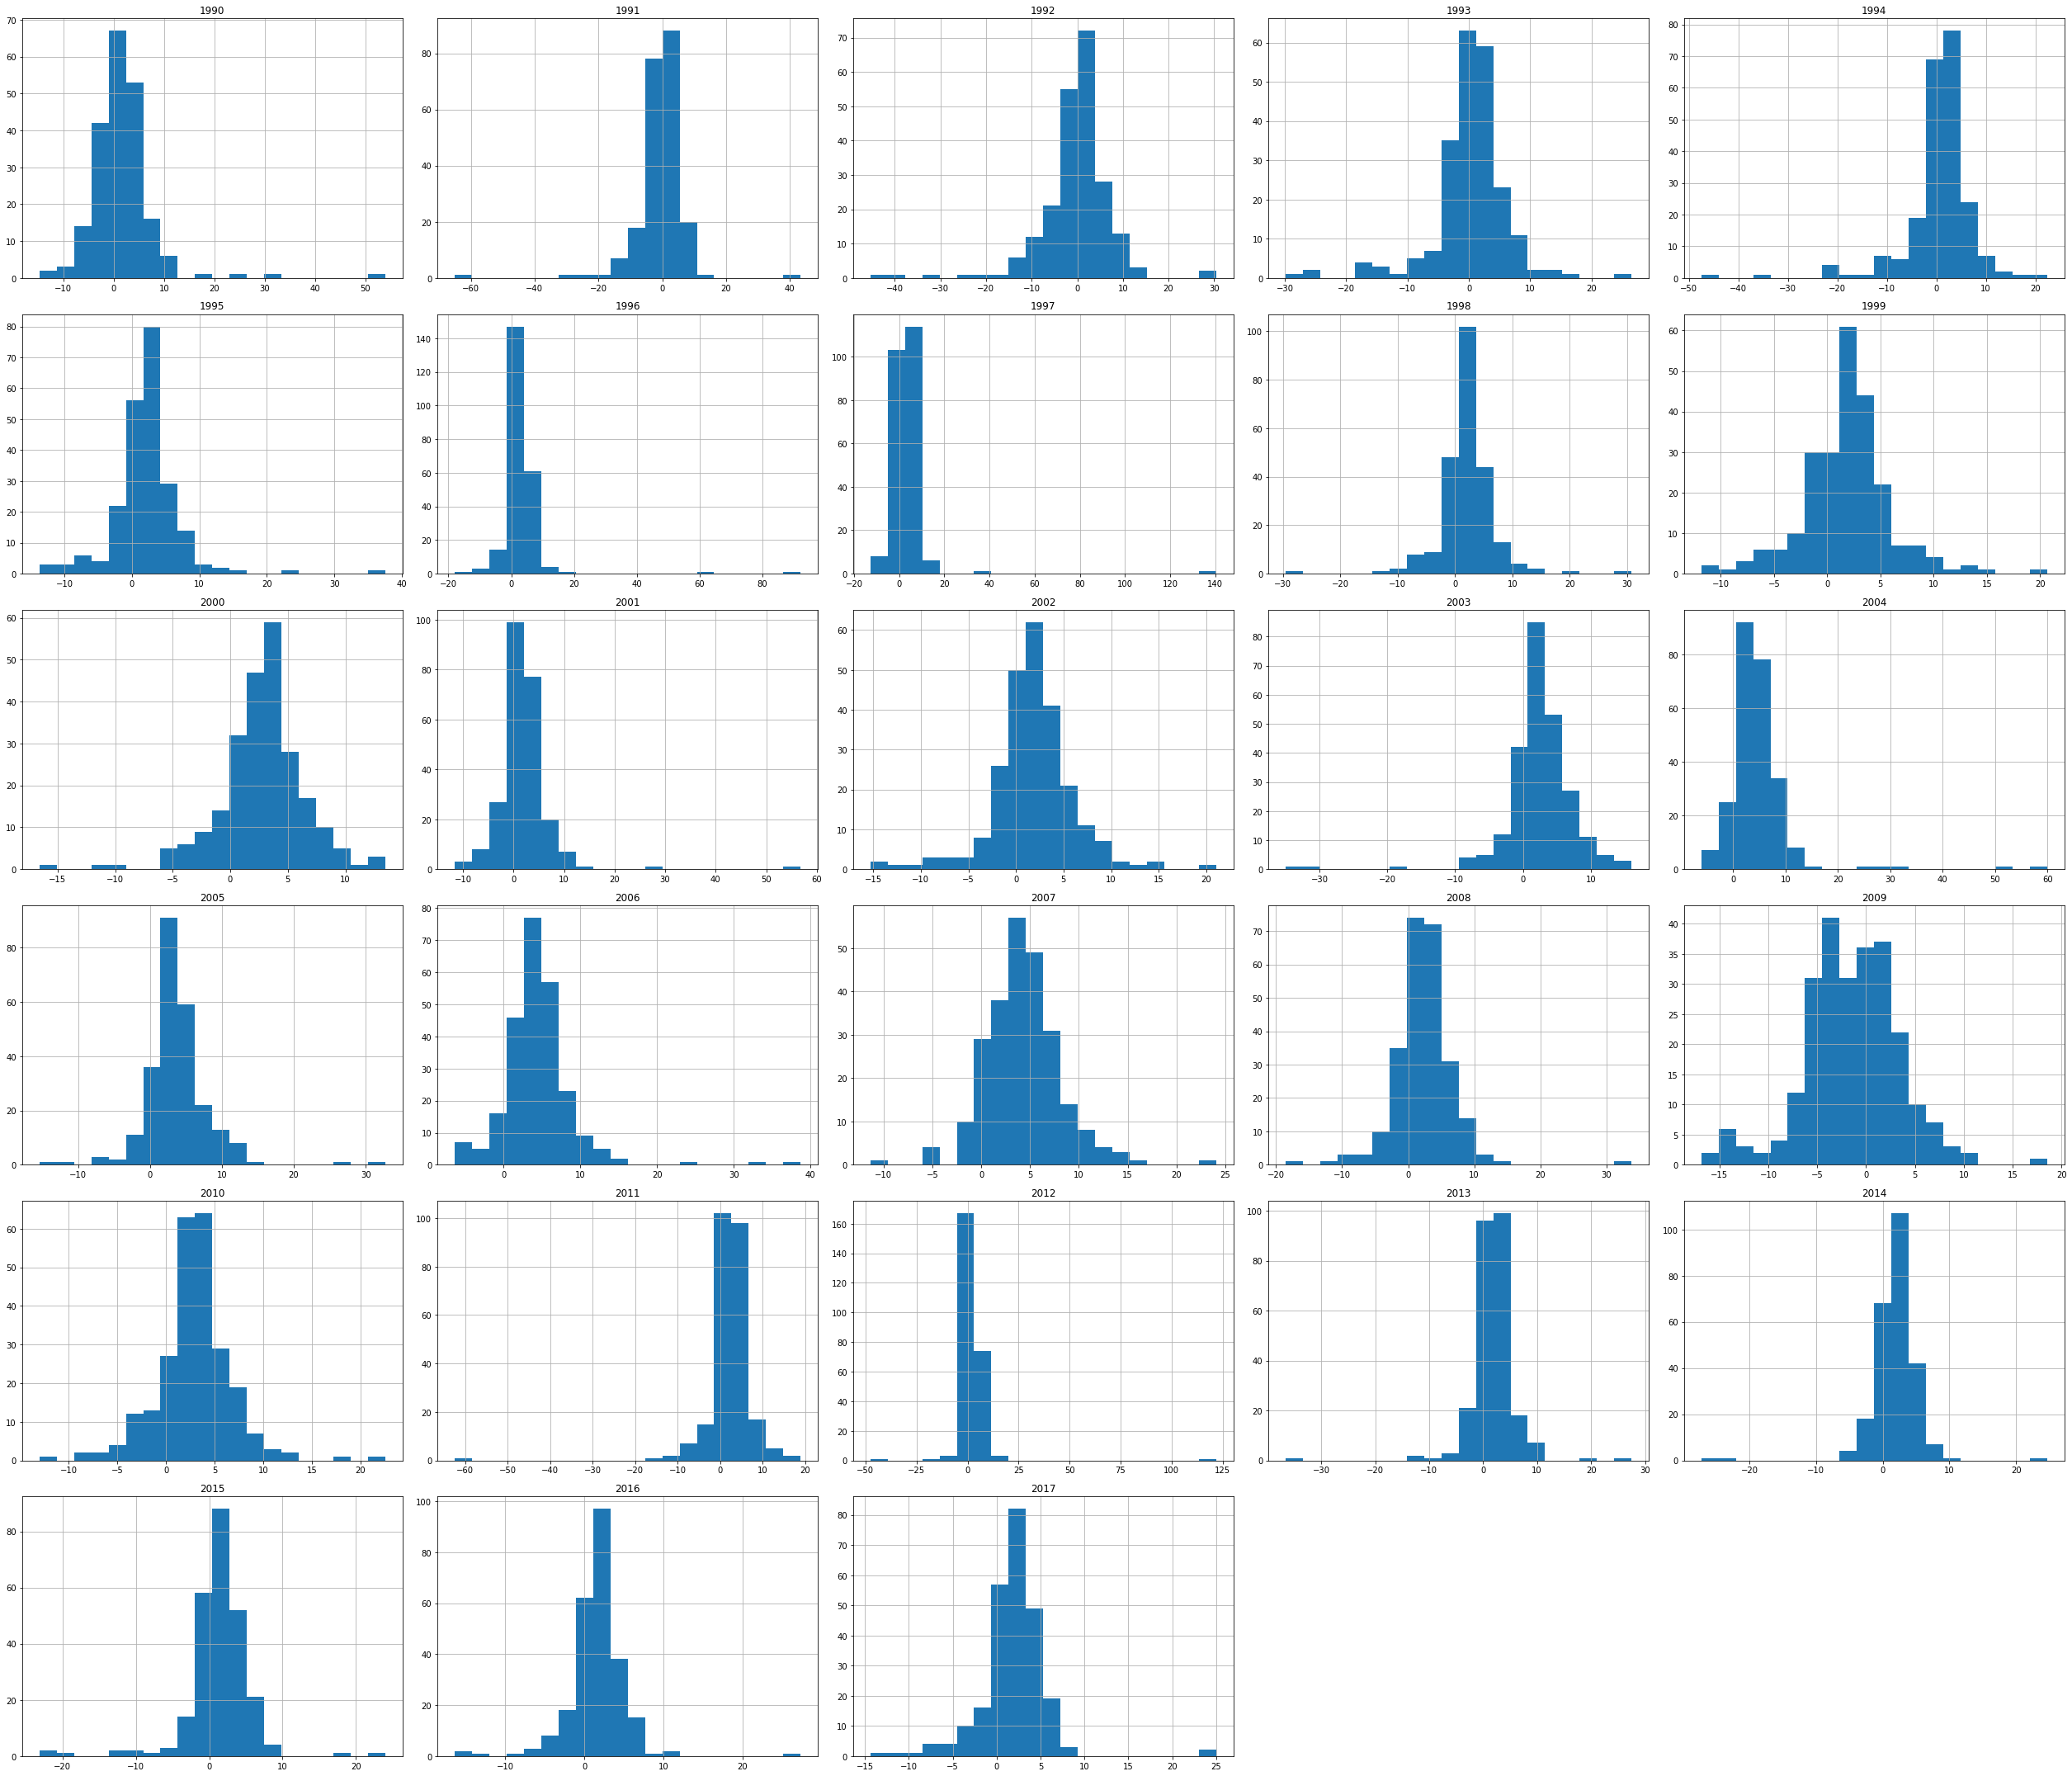

                                     CountryName        avg
86                             Equatorial Guinea  14.383944
177                                        Nauru  13.441598
22                        Bosnia and Herzegovina  10.811663
38                                         China   8.698387
158                                      Myanmar   7.664357
59   East Asia & Pacific (excluding high income)   7.063876
228   East Asia & Pacific (IDA & IBRD countries)   7.062827
235                                  Timor-Leste   6.199368
111                                         Iraq   5.683611
141                                    Lithuania   5.519613


In [8]:
capita_growth = pd.read_excel("./Data/capita_growth.xls")
capita_growth.rename(columns={"Country Name":"CountryName","Country Code":"CountryCode"},inplace=True)
capita_growth.drop(capita_growth.columns[[range(2,34)]], axis=1,inplace=True)
capita_growth.drop("2018", axis=1, inplace=True)
capita_growth.drop("2019", axis=1, inplace=True)
capita_growth.head(5)

capita_growth_head  = capita_growth.head(5)
capita_growth_stats = capita_growth.loc[:,[str(e) for e in list(range(1990,2018))]]

print("Head of Capita Growth data: \n",capita_growth_head)
print("Basic statistics about Capita Growth data: \n", capita_growth_stats.describe())
print("Number of Null values by column \n", capita_growth.isnull().sum(axis=0))

capita_growth_dropped = capita_growth.dropna(how='all')
capita_growth_dropped.hist(figsize=(35,30),
                  bins=20)
plt.tight_layout()
plt.show()

capita_growth_dropped['avg'] = capita_growth_dropped.mean(axis=1)
print(capita_growth_dropped.loc[:,['CountryName','avg']].nlargest(10,'avg'))

# Data Cleaning / Merging / etc
**World Bank Data**
* Interpolating Missing Values
* Rounding Values where fitting
* Calculating Average for each country (Used in plotting)
* Filtering for Countries that are available in Terrorism dataset


**Terrorism Data**
* Around 9.000 terror attacks cannot be assigned to a country with gdp (International)
* 153 Countries of the GDP dataset have had a terror attack between 1991 and 2018
* Mapping Country Names of Terrorism Database to World Bank Names
* Performing ISO-Lookup for the countries (ISO-3)
* Exclude Big Attacks with over 350 Deaths as outliers
* Grouping terrorist attacks by country and by country+year
* No Data for Year 1993 (and 2018) -> interpolation for 1993

**Combination of Datasets**
* Generation of new Dataframe
* Country Information: Name + Code
* GDP Information: Log_Scaled, Standardized, Change%, Small Country (=0,25Quantile)
* Capita Information: Standardized, Change%
* Unemployment
* Life Expectancy
* Terroristic Information
* Generation of Information about past terrorist activity in countries (Last_Year, Last_3_Years, Last_5_Years)

Economical and Social Data is added from the year before. For the prediction part this will not be able for the target year, as the prediction would happen at the start of a year. Therefore data of the previous year is needed.

In [9]:
# Compute the average values (later used in plotting) over the years 1992-2018
gdp["Average"] = gdp[gdp.keys()[2:]].mean(axis=1)
capita["Average"] = capita[capita.keys()[2:]].mean(axis=1)
unemp["Average"] = unemp[unemp.keys()[2:]].mean(axis=1)
life["Average"] = life[life.keys()[2:]].mean(axis=1)
capita_growth["Average"] = capita_growth[capita_growth.keys()[2:]].mean(axis=1)

In [10]:
#round the world bank data values
gdp = round(gdp)
capita = round(capita,3)
unemp = round(unemp,3)
life = round(life,3)
capita_growth = round(capita_growth,3)

In [11]:
# Interpolate missing values row-wise (by country)
gdp[gdp.keys()[2:30]] = gdp[gdp.keys()[2:30]].interpolate(method="linear",limit_direction='both',axis=1)
capita[capita.keys()[2:30]] = capita[capita.keys()[2:30]].interpolate(method="linear",limit_direction='both',axis=1)
unemp[unemp.keys()[2:30]] = unemp[unemp.keys()[2:30]].interpolate(method="linear",limit_direction='both',axis=1)
life[life.keys()[2:30]] = life[life.keys()[2:30]].interpolate(method="linear",limit_direction='both',axis=1)
capita_growth[capita_growth.keys()[2:30]] = capita_growth[capita_growth.keys()[2:30]].interpolate(method="linear",limit_direction='both',axis=1)

In [12]:
# Disregard "big" terrorist attacks with 350 or more killed. These datapoints are
# outliers and therefore not reasonable for analysis.
# Example 9/11 or Omu Shinrikyo (Tokio Subway Poison Attack)
terror = terror[terror.Killed<350]


# Mapping of Countries to official UN Names
terror = terror.replace({'Country': {"Russia":"Russian Federation",
                                     "Czech Republic":"Czechia",
                                     "Slovak Republic":"Slovakia",
                                     "Iran":"Iran, Islamic Republic of",
                                     "Syria":"Syrian Arab Republic",
                                     "Venezuela":"Venezuela, Bolivarian Republic of",
                                     "North Korea":"Korea, Democratic People's Republic of",
                                     "South Korea":"Korea, Republic of",
                                     "Democratic Republic of the Congo":"Congo, The Democratic Republic of the",
                                     "Zaire":"Congo, The Democratic Republic of the",
                                     "Republic of the Congo":"Congo",
                                     "Bolivia":"Bolivia, Plurinational State of",
                                     "Bosnia-Herzegovina":"Bosnia and Herzegovina",
                                     "Brunei":"Brunei Darussalam",
                                     "East Timor":"Timor-Leste",
                                     "Ivory Coast":"Côte d'Ivoire",
                                     "Tanzania":"Tanzania, United Republic of",
                                     "Vietnam":"Viet Nam",
                                     "Taiwan":"Taiwan, Province of China",
                                     "Macedonia":"North Macedonia",
                                     "Moldova":"Moldova, Republic of",
                                     "Laos":"Lao People's Democratic Republic",
                                     "Serbia-Montenegro":"Montenegro",
                                     "Swaziland":"Eswatini",
                                     "Macau":"Macao",
                                     "St. Kitts and Nevis":"Saint Kitts and Nevis",
                                     "St. Lucia":"Saint Lucia",
                                     "West Bank and Gaza Strip":"Palestine, State of"}})



terror = terror.replace("Kosovo","Serbia") #not available in the UN-Data.
terror = terror.replace("Yugoslavia","Serbia") #since 2006 official successor
terror = terror.replace("Czechoslovakia","Czechia") #Czechia as the bigger successor of Czechoslovakia
terror = terror.replace("East Germany (GDR)","Germany") #Already united in 1992
terror = terror.replace("West Germany (FRG)","Germany") #Already united in 1992
terror = terror.replace("Soviet Union","Russian Federation") #Already fell apart in 1992

print(len(terror)-sum(terror.Country.isin(gdp.CountryName).astype(int)))
# Around 9.000 Terror attacks cannot be assigned to a country with gdp
print(sum(gdp.CountryName.isin(terror.Country).astype(int)))
#154 Countries from gdp are also in the terrorism dataset.
#Numbers might change further depending on preprocessing

8857
153


In [13]:
#Grouping the dataset by Attacks and Casualities
terrorgroup = pd.DataFrame()
terrorgroup[["Attacks","Casualities"]] = terror.groupby("Country").agg({'Country':'count', 'Casualities': 'sum'})

In [14]:
# ISO lookup
input_countries = terrorgroup.index.values

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

codes = [countries.get(country, 'Unknown code') for country in input_countries]

# Adding to dataframe
terrorgroup["ISO"]=codes
terrorgroup["Country"]=terrorgroup.index.values

NameError: name 'pycountry' is not defined

In [ ]:
# Generating datasets for attacks and casualities
# Split up by Year (for every country for every year)
# Data from 1993 is missing. -> backward interpolation
terroryear = pd.DataFrame()
terroryear[["Attacks","Casualities"]] = terror.groupby(["Country","Year"]).agg({'Country':'count', 'Casualities': 'sum'})
terroryear.reset_index(inplace=True)
terroryear["ISO"]=[countries.get(country, 'Unknown code') for country in terroryear.Country]

test = pd.DataFrame()
test["Country"]=gdp.CountryName.unique()
test["ISO"]=gdp.CountryCode.unique()

for i in range(1991,2018):
    test[str(i)]=0
    df=terroryear[terroryear.Year==i]
    for j in df.Country.unique():
        test.loc[test.Country==j, [str(i)]] = df.loc[df.Country==j,"Attacks"].unique()[0]

test["1993"]=np.nan
test[test.keys()[2:29]] = round(test[test.keys()[2:29]].interpolate(method="linear",limit_direction='backward',axis=1,limit_area="inside"))
test[test.keys()[2:29]] = test[test.keys()[2:29]].astype('int32')
terrorattacks = test


test = pd.DataFrame()
test["Country"]=gdp.CountryName.unique()
test["ISO"]=gdp.CountryCode.unique()
for i in range(1991,2018):
    test[str(i)]=0
    df=terroryear[terroryear.Year==i]
    for j in df.Country.unique():
        #if(df.loc[df.Country==j,"Casualities"].unique()[0]>3000):
            #test.loc[test.Country==j, [str(i)]]=np.nan
       # else:
        test.loc[test.Country==j, [str(i)]] = df.loc[df.Country==j,"Casualities"].unique()[0]

test["1993"]=np.nan
test[test.keys()[2:29]] = round(test[test.keys()[2:29]].interpolate(method="linear",limit_direction='both',axis=1))
test[test.keys()[2:29]] = test[test.keys()[2:29]].astype('int32')
terrorkilled = test

In [ ]:
# Drop Countries where no Terrorist attacks are available
# Focus on countries that are available in both datasets.
unemp = unemp.fillna(unemp.mean()) #Impute with mean for "Antigua and Barbuda" and "Dominica"
gdp_terror = gdp[terrorattacks.sum(axis=1)!=0]
capita_terror = capita[terrorattacks.sum(axis=1)!=0]
unemp_terror = unemp[terrorattacks.sum(axis=1)!=0]
life_terror = life[terrorattacks.sum(axis=1)!=0]
growth_terror = capita_growth[terrorattacks.sum(axis=1)!=0]

terrorkilled = terrorkilled[terrorattacks.sum(axis=1)!=0]
terrorattacks = terrorattacks[terrorattacks.sum(axis=1)!=0]

In [ ]:
# Generating a dataset for model building.
# Include different measures for GDP (log,normalized,change in %)
# Calculate values for previous terrorist attacks
test=pd.DataFrame()
for i in range(1992,2018):
    empty=pd.DataFrame()
    empty["Country"]=gdp_terror.CountryName
    empty["Code"]=gdp_terror.CountryCode
    empty["Year"]=i
    empty["Small_Country"]=(gdp_terror[str(i-1)]<=np.quantile(gdp_terror[str(i-1)],0.25))
    empty["GDP_log"]=np.log(gdp_terror[str(i-1)])
    empty["GDP_normal"]=(gdp_terror[str(i-1)]-gdp_terror[str(i-1)].mean())/gdp_terror[str(i-1)].std()
    empty["GDP_change"]=(gdp_terror[str(i-1)]-gdp_terror[str(i-2)])/gdp_terror[str(i-2)]
    empty["GDP_per_Capita"]=capita_terror[str(i-1)]/capita_terror[str(i-1)].max()
    empty["GDP_per_Capita_Change"]=growth_terror[str(i-1)]
    empty["Unemployment"]=unemp_terror[str(i-1)]
    empty["Life_Expectancy"]=life_terror[str(i-1)]
    empty["Terrorist_Attacks"]=terrorattacks[str(i)]
    empty["Casualities"]=terrorkilled[str(i)]
    if(i<=1992):
        empty["Trend"]=0
    else:
        x=terrorattacks[str(i-1)]-terrorattacks[str(i-2)]
        x.reset_index(drop=True,inplace=True)
        for j in range(0,len(x)):
            x[x[j]>0]=1
            x[x[j]<0]=-1
        empty["Trend"]=list(x)

        
    if(i<=1993):
        if(i==1991):
            empty["Attacks_last_3_Years"] = terrorattacks[str(i)]
            empty["Casualities_last_3_Years"] = terrorkilled[str(i)]
        else:
            empty["Attacks_last_3_Years"] = terrorattacks[(str(i) for i in list(range(1991,i)))].mean(axis=1)
            empty["Casualities_last_3_Years"] = terrorkilled[(str(i) for i in list(range(1991,i)))].mean(axis=1)
    else:
        empty["Attacks_last_3_Years"] = terrorattacks[(str(i) for i in list(range(i-3,i)))].mean(axis=1)
        empty["Casualities_last_3_Years"] = terrorkilled[(str(i) for i in list(range(i-3,i)))].mean(axis=1)

        
    if(i<=1995):
        if(i<=1991):
            empty["Attacks_last_5_Years"] = terrorattacks[str(i)]
            empty["Casualities_last_5_Years"] = terrorkilled[str(i)]
        else:
            empty["Attacks_last_5_Years"] = terrorattacks[(str(i) for i in list(range(1991,i)))].mean(axis=1)
            empty["Casualities_last_5_Years"] = terrorkilled[(str(i) for i in list(range(1991,i)))].mean(axis=1)
    else:
        empty["Attacks_last_5_Years"] = terrorattacks[(str(i) for i in list(range(i-5,i)))].mean(axis=1)
        empty["Casualities_last_5_Years"] = terrorkilled[(str(i) for i in list(range(i-5,i)))].mean(axis=1)
    
    
    if(i==1991):
        empty["Attacks_last_Year"]=round(terrorattacks[str(i)])
        empty["Casualities_last_Year"]=round(terrorkilled[str(i)])
    else:
        empty["Attacks_last_Year"]=terrorattacks[str(i-1)]
        empty["Casualities_last_Year"]=terrorkilled[str(i-1)]


    empty["High_Terrorism"]=(empty["Casualities_last_5_Years"]>100)
    empty["Medium_Terrorism"]=(empty.Casualities_last_5_Years<=100)&(empty.Casualities_last_5_Years>5)
    empty["Low_Terrorism"]=(empty.Casualities_last_5_Years<=5)
    
    
    if(len(test)==0):
        test=empty.copy()
    else:
        test = test.append(empty,ignore_index=True)
fulldata = test.copy()

# Hypotheses
## Correlations
* Does unemployment influence terrorism within a country?
* Does GDP per capita influence terrorism within a country?

For both Hypotheses we compare the average values of terrorism in a country with the repsective average values of Unemployment or GDP per capita. Scatterplots for both Hypotheses are in Section "Data Visualization"

For Unemployment we calculate a correlation of -0.04 and for Unemployment -0.1. In both cases these correlation values fall below the absolute 0.3 threshold that we set in the beginning. Therefore we keep the Hypotheses, that terrorism is not correlated with these variables.

However, a combination of these variables could still influence terrorism. Therefore we will examine which of our variables have an influence on terrorism in the next step. We will try to build models and predict terrorism with our data in the next step.

## Predictions
* Which economical and social influences have an influence terrorism?
* What data is necessary to predict terrorism in the next year?

We use prediction models to answer these questions. We obtain the Regression Coefficient from Ridge Regression aswell as the Variable Importance from Random Forest to make a decision which variables have an influence on terrorism.

Prediction with 
* Ridge Regression (alpha=1)
* Random Forest (n_estimators=100)

In a first step we use only **economical and social** data for the models. In a later step we will include **previous terrorist data** to see, if it improves our model and enables good predictions.

General Remarks:
* Time-based Train-Test-Split (2018 used for test set)
* Economical and Social Data has Importance [0,25] (Random Forest)
* Ridge, Lasso and Regression have pretty equal performance
* Regression Methods may predict less than 0 Casualities -> Cut to 0
* Very bad performance from Regression Models (over 300 MAE)
* Excluding heavy outliers (over 1000 casualities) results in high increase of performance for both estimators
* Including Past Terrorist Data Improves the models
* Best performance can be achieved with Random Forest by excluding outliers and including past terrorist data.

In [ ]:
terrorkilled_avg = terrorkilled[terrorkilled.keys()[2:]].mean(axis=1)
np.corrcoef(unemp_terror.Average,terrorkilled_avg)

In [ ]:
# Correlation between Unemployment and Casualities
np.corrcoef(capita_terror.Average,terrorkilled_avg)

In [ ]:
#Selecting a subset of data (economic and social data) for the first model
test = fulldata#.loc[fulldata.Casualities<1000] #Possibility of Excluding high casualities
test = test.loc[test.Year!=1991]
predictors = ["Small_Country","GDP_per_Capita","GDP_log","GDP_normal","GDP_change",
              'Unemployment','Life_Expectancy',"GDP_per_Capita_Change"]
X = test[predictors]
Y = test["Casualities"]

In [ ]:
# Alpha=1 performs best in RidgeCV
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1,10,100,1000],store_cv_values=True)
mod = clf.fit(X, Y)
np.mean(mod.cv_values_, axis=0)

In [ ]:
# Time-based Train-Test-Split. Use 2018 for prediction
year = 2017
X_train = X.loc[test.Year<=year]
X_test = X.loc[test.Year==year]
Y_train = Y.loc[test.Year<=year]
Y_test = Y.loc[test.Year==year]


tree = RandomForestRegressor(n_estimators=100)
tree.fit(X_train, Y_train) 
#regr = LinearRegression()
regr = Ridge(alpha=1)
regr.fit(X_train, Y_train) 

#coeff = pd.DataFrame()
#coeff["Name"]=predictors
#coeff["Value"]=np.around(regr.coef_,2)
#coeff


In [ ]:
# Make predictions
# Random Forests perform very good. Ridge rather bad
pred_tree = tree.predict(X_test)
print("MAE Random Forest:", metrics.mean_absolute_error(pred_tree,Y_test))
print("RMSE Random Forest:", math.sqrt(metrics.mean_squared_error(pred_tree,Y_test)))

pred_regr = regr.predict(X_test)
pred_regr[pred_regr<0]=0
print("MAE Ridge Regression:", metrics.mean_absolute_error(pred_regr,Y_test))
print("RMSE Ridge Regression:", math.sqrt(metrics.mean_squared_error(pred_regr,Y_test)))

In [ ]:
# Get Regression Coefficient and Random Forest Importance for the variables
coef = pd.DataFrame()
coef["Name"]=predictors
coef["Coefficient"]=regr.coef_
coef["Importance"]=tree.feature_importances_
coef

In [ ]:
# Compare the predictions for 2018.
comp1 = pd.DataFrame()
comp1["Country"]=test.loc[test.Year==year,"Country"]
comp1["Casualities"]=Y_test
comp1["RandomForest"]=np.round(pred_tree)
comp1["Regression"]=np.round(pred_regr)

comp1

In [ ]:
plt.scatter(Y_test, pred_tree, linewidth=2)
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.xlim(-5, 1000)
plt.ylim(-5, 1000)
plt.show()

Prediction based on economical and social data does not work well with the regression. It fails especially for countries with high Casualities (Afghanistan) as it heavily underpredicts. A solution to this would be the usage of previous terrorism data.
Random Forests already perform quite good on the data. We expect the performance to increase further by including previous data.

In [ ]:
#
# Including previous terrostic activity
#

predictors = ["Small_Country","GDP_per_Capita","GDP_log","GDP_normal","GDP_change",
              'Unemployment','Life_Expectancy',"GDP_per_Capita_Change",
              "Casualities_last_Year","Casualities_last_5_Years","Trend",
              "High_Terrorism","Medium_Terrorism","Low_Terrorism"]
X2 = test[predictors]
Y2 = test["Casualities"]

year = 2017
X2_train = X2.loc[test.Year<=year]
X2_test = X2.loc[test.Year==year]
Y2_train = Y2.loc[test.Year<=year]
Y2_test = Y2.loc[test.Year==year]


tree2 = RandomForestRegressor(n_estimators=100)
tree2.fit(X2_train, Y2_train) 
#regr = LinearRegression()
regr2 = Ridge(alpha=1)
regr2.fit(X2_train, Y2_train)

pred_tree2 = tree2.predict(X2_test)
print("MAE Random Forest:", metrics.mean_absolute_error(pred_tree2,Y2_test))
print("RMSE Random Forest:", math.sqrt(metrics.mean_squared_error(pred_tree2,Y2_test)))


pred_regr2 = regr2.predict(X2_test)
pred_regr2[pred_regr2<0]=0
print("MAE Ridge Regression:", metrics.mean_absolute_error(pred_regr2,Y2_test))
print("RMSE Ridge Regression:", math.sqrt(metrics.mean_squared_error(pred_regr2,Y2_test)))

comp2 = pd.DataFrame()
comp2["Country"]=test.loc[test.Year==year,"Country"]
comp2["Casualities"]=Y2_test
comp2["RandomForest"]=np.round(pred_tree2)
comp2["Regression"]=np.round(pred_regr2)

comp2

In [ ]:
plt.scatter(Y2_test, pred_tree2, linewidth=2)
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.xlim(-5, 1000)
plt.ylim(-5, 1000)
plt.show()

Including previous terrorist data helps the Regression Model as it provides a starting point for countries with very high terrorist activity. It seems, that the level on terrorism is also heavily dependent on the previous activity of terrorism.

In the last try we exclude the countries with very high terrorist activity (>1000 Casualities per Year) and build two models. As we reduce the span of casualities to the range of 0-1000 we suspect that the mean average error will reduce further.

In [ ]:
#
# Including previous terrostic activity, excluding high outliers
#

test2 = fulldata.loc[fulldata.Casualities<1000] #Possibility of Excluding high casualities
predictors = ["Small_Country","GDP_per_Capita","GDP_log","GDP_normal","GDP_change",
              'Unemployment','Life_Expectancy',"GDP_per_Capita_Change",
              "Casualities_last_Year","Casualities_last_5_Years","Trend",
              "High_Terrorism","Medium_Terrorism","Low_Terrorism"]
X3 = test2[predictors]
Y3 = test2["Casualities"]

year = 2017
X3_train = X3.loc[test2.Year<year]
X3_test = X3.loc[test2.Year==year]
Y3_train = Y3.loc[test2.Year<year]
Y3_test = Y3.loc[test2.Year==year]


tree3 = RandomForestRegressor(n_estimators=100)
tree3.fit(X3_train, Y3_train) 
#regr = LinearRegression()
regr3 = Ridge(alpha=1)
regr3.fit(X3_train, Y3_train)

pred_tree3 = tree3.predict(X3_test)
print("MAE Random Forest:", metrics.mean_absolute_error(pred_tree3,Y3_test))
print("RMSE Random Forest:", math.sqrt(metrics.mean_squared_error(pred_tree3,Y3_test)))

pred_regr3 = regr3.predict(X3_test)
pred_regr3[pred_regr3<0]=0
print("MAE Ridge Regression:", metrics.mean_absolute_error(pred_regr3,Y3_test))
print("RMSE Ridge Regression:", math.sqrt(metrics.mean_squared_error(pred_regr3,Y3_test)))

comp3 = pd.DataFrame()
comp3["Country"]=test2.loc[test.Year==year,"Country"]
comp3["Casualities"]=Y3_test
comp3["RandomForest"]=np.round(pred_tree3)
comp3["Regression"]=np.round(pred_regr3)

comp3

In [ ]:
plt.scatter(Y3_test, pred_tree3, linewidth=2)
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.xlim(-5, 1000)
plt.ylim(-5, 1000)
plt.show()

Lots of countries in the dataset have not experienced Casualities within 2018. The Random Forest Model manages to correctly identify these countries while also providing reasonable predictions for countries with actual Casualities. Overall, the Random Forest Model is performing very good based on MAE.

# Data Visualization
Contains the following plots:
* Correlation Plots to Hypotheses
* Terrorism world plot
* Terrorism EU Plot
* GDP per capita world plot


In [ ]:
df = pd.DataFrame()
df["Year"]=capita_terror.keys()[2:29]
df["GDP per capita"]=capita_terror[capita_terror.keys()[2:29]].mean().values
df["Casualities"]=terrorkilled[terrorkilled.keys()[2:29]].sum().values
fig = px.scatter(df, x="GDP per capita", y="Casualities",title="GDP per capita vs. Casualities")
fig.show()

In [ ]:
df = pd.DataFrame()
df["Year"]=unemp_terror.keys()[2:29]
df["Unemployment_Rate"]=unemp_terror[unemp_terror.keys()[2:29]].mean().values
df["Casualities"]=terrorkilled[terrorkilled.keys()[2:29]].sum().values
fig = px.scatter(df, x="Unemployment_Rate", y="Casualities",title="Unemployment Rate vs. Casualities")
fig.show()

In [ ]:
bins = [0, 100, 500, 1000, 4000, 8000, 200000]
labels = ["1","2","3","4","5","6"]
terrorplot = terrorgroup.copy()
terrorplot["Attack_Group"] = pd.cut(terrorplot["Attacks"], bins=bins, labels=labels)
fig = px.choropleth(terrorplot, locations="ISO",
                    color="Attack_Group", # lifeExp is a column of gapminder
                    hover_name="Country",
                    hover_data=["ISO","Attacks"],
                    title="Terrorist attacks between 1991 and 2017",# column to add to hover information
                    color_continuous_scale=px.colors.sequential.Reds)
fig.show()

In [ ]:
bins = [0, 100, 500, 1000, 5000, 15000, 200000]
labels = ["1","2","3","4","5","6"]
terrorplot = terrorgroup.copy()
terrorplot["Attack_Group"] = pd.cut(terrorplot["Casualities"], bins=bins, labels=labels)
fig = px.choropleth(terrorplot, locations="ISO",
                    color="Attack_Group", # lifeExp is a column of gapminder
                    hover_name="Country",
                    hover_data=["ISO","Casualities"],
                    title="Casualities of Terrorist attacks between 1991 and 2017",# column to add to hover information
                    color_continuous_scale=px.colors.sequential.Reds)
fig.show()

In [ ]:
bins = [0, 1000, 5000, 10000, 30000, 50000, 200000]
labels = ["1","2","3","4","5","6"]
df = capita.copy()
df['GDP_Group'] = pd.cut(df['2018'], bins=bins, labels=labels)
fig = px.choropleth(df, locations="CountryCode",
                    color="GDP_Group", # lifeExp is a column of gapminder
                    hover_name="CountryName",
                    hover_data=["CountryCode","2018"],
                    title="GDP per Capita 2018",
                    scope="world")

fig.show()

In [ ]:
#bins = [0, 1000, 5000, 10000, 30000, 50000, 200000]
#labels = ["1","2","3","4","5","6"]
df = unemp.copy()
#df['GDP_Group'] = pd.cut(df['2018'], bins=bins, labels=labels)
fig = px.choropleth(df, locations="CountryCode",
                    color="2018", # lifeExp is a column of gapminder
                    hover_name="CountryName",
                    hover_data=["CountryCode","2018"],
                    title="Unemployment in 2018",
                    scope="world",
                    color_continuous_scale=px.colors.sequential.Reds)

fig.show()

In [ ]:
#bins = [0, 1000, 5000, 10000, 30000, 50000, 200000]
#labels = ["1","2","3","4","5","6"]
df = life.copy()
#df['GDP_Group'] = pd.cut(df['2018'], bins=bins, labels=labels)
fig = px.choropleth(df, locations="CountryCode",
                    color="2017", # lifeExp is a column of gapminder
                    hover_name="CountryName",
                    hover_data=["CountryCode","2017"],
                    title="Life Expectancy in 2017",
                    scope="world",
                    color_continuous_scale=px.colors.sequential.Viridis)

fig.show()

In [ ]:
bins = [0, 25,50, 100, 500, 2000, 10000]
labels = ["1","2","3","4","5","6"]
terrorplot = terrorgroup.copy()
terrorplot["Attack_Group"] = pd.cut(terrorplot["Attacks"], bins=bins, labels=labels)
fig = px.choropleth(terrorplot, locations="ISO",
                    color="Attack_Group", # lifeExp is a column of gapminder
                    hover_name="Country",
                    hover_data=["ISO","Attacks"],
                    scope="europe",
                    title="Terrorist attacks in Europe between 1991 and 2018",# column to add to hover information
                    color_continuous_scale=px.colors.sequential.Reds)
fig.show()

In [ ]:
df = fulldata.loc[fulldata.Country=="Germany"]
fig = px.line(df, x="Year", y="Casualities",title="Terror Attacks in Germany by Year 1991-2017")
fig.show()

In [ ]:
df = pd.DataFrame()
df["Year"]=terrorattacks.keys()[2:29]
df["Attacks"]=terrorattacks[terrorattacks.keys()[2:29]].sum().values
fig = px.line(df, x="Year", y="Attacks",title="Terror Attacks by Year 1991-2017")
fig.show()

In [ ]:
df = pd.DataFrame()
df["Year"]=terrorkilled.keys()[3:29]
df["Attacks"]=terrorkilled[terrorkilled.keys()[3:29]].sum().values
fig = px.line(df, x="Year", y="Attacks",title="Terror Casualities by Year 1992-2017")
fig.show()

In [ ]:
df = pd.DataFrame()
df["Year"]=gdp_terror.keys()[3:29]
df["GDP"]=gdp_terror[gdp_terror.keys()[3:29]].sum().values
fig = px.line(df, x="Year", y="GDP",title="Evolution of GDP worldwide")
fig.show()

In [ ]:
df = pd.DataFrame()
df["Year"]=capita_terror.keys()[2:29]
df["GDP"]=gdp_terror[capita_terror.keys()[2:29]].mean().values
df["Attacks"]=terrorattacks[terrorattacks.keys()[2:29]].sum().values
fig = px.scatter(df, x="GDP", y="Attacks",title="GDP Worldwide vs Terrorist Attacks")
fig.show()

In [ ]:
df = pd.DataFrame()
df["Year"]=life_terror.keys()[2:29]
df["GDP"]=life_terror[life_terror.keys()[2:29]].mean().values
df["Attacks"]=terrorattacks[terrorattacks.keys()[2:29]].sum().values
fig = px.scatter(df, x="GDP", y="Attacks",title="Life Expectancy Worldwide vs Terrorist Attacks")
fig.show()

In [ ]:
#df = pd.DataFrame()
#df["Year"]=gdp_terror.keys()[2:29]
#df["Value"]=gdp_terror[capita_terror.keys()[2:29]].mean().values/gdp_terror[capita_terror.keys()[2:29]].mean().max()*100
#df["Type"]="GDP"
#df1 = pd.DataFrame()
#df1["Year"]=capita_terror.keys()[2:29]
#df1["Value"]=capita_terror[capita_terror.keys()[2:29]].mean().values/capita_terror[capita_terror.keys()[2:29]].mean().max()*100
#df1["Type"]="GDP per capita"
#df2 = pd.DataFrame()
#df2["Year"]=terrorattacks.keys()[2:29]
#df2["Value"]=terrorattacks[capita_terror.keys()[2:29]].mean().values/terrorattacks[capita_terror.keys()[2:29]].mean().max()*100
#df2["Type"]="Terror Attacks"
#df3=pd.DataFrame()
#df3["Year"]=unemp_terror.keys()[2:29]
#df3["Value"]=unemp_terror[capita_terror.keys()[2:29]].mean().values
#df3["Type"]="Unemployment"

#df4=pd.DataFrame()
#df4["Year"]=life_terror.keys()[2:29]
#df4["Value"]=life_terror[capita_terror.keys()[2:29]].mean().values
#df4["Type"]="Life Expectancy"

#df = df.append(df1,ignore_index = True)
#df = df.append(df2,ignore_index = True)
#df = df.append(df3,ignore_index = True)
#df = df.append(df4,ignore_index = True)

#fig = px.line(df, x="Year", y="Value",color="Type",title="GDP worldwide vs. GPD per capita vs. Terrorist Attacks")
#fig.show()